# **Import Libraries :**

In [1]:
import os
import glob
import random
import numpy as np
import cv2
import tifffile as tiff
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, jaccard_score
import seaborn as sns
import matplotlib.pyplot as plt

# **Prepare Some Functions To Be Used :**

## Normalization & Contrast stretching functions :

In [2]:
# Normalization function
def normalize_image(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)

# Contrast stretching function
def contrast_stretching(image):
    p2, p98 = np.percentile(image, (2, 98))  
    return np.clip((image - p2) / (p98 - p2 + 1e-8), 0, 1)

## Visualizing Bands In Gray Colors function :

In [3]:
def visualize_bands(image, title="Image Bands", cmap="gray"):
    num_bands = image.shape[-1]
    fig, axes = plt.subplots(1, num_bands, figsize=(20, 3))
    fig.suptitle(title, fontsize=14)

    for i in range(num_bands):
        ax = axes[i] if num_bands > 1 else axes
        ax.imshow(image[:, :, i], cmap=cmap)
        ax.set_title(f"Band {i+1}")
        ax.axis("off")

    plt.show()

# **Reading The Data Directories :**

In [4]:
image_dir = "/kaggle/input/satellites-dataset/data/images"
mask_dir = "/kaggle/input/satellites-dataset/data/labels"


image_paths = sorted(glob.glob(os.path.join(image_dir, "*.tif")))
mask_paths = [p for p in sorted(glob.glob(os.path.join(mask_dir, "*.png"))) if "_" not in os.path.basename(p)]


images = [tiff.imread(img_path) for img_path in image_paths]
masks = [cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) for mask_path in mask_paths]

# **Applying Some Pre-Processing The Images :**

In [5]:
normalized_images = [normalize_image(img) for img in images]
contrast_images = [contrast_stretching(img) for img in normalized_images]
images=contrast_images

# **Visualizing Some Images Bands :**

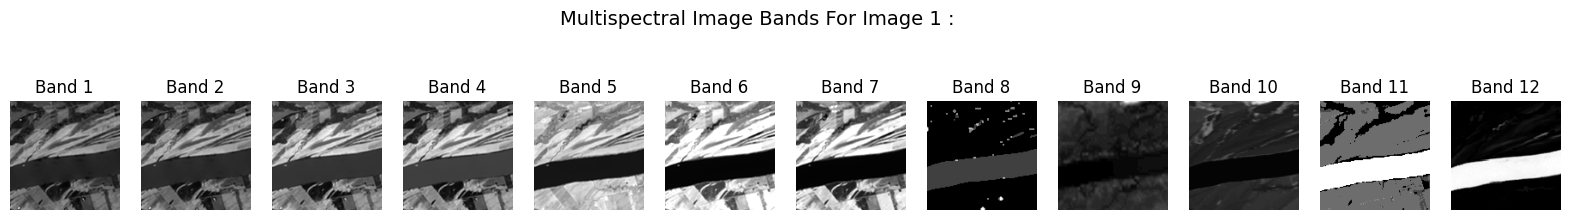

In [6]:
visualize_bands(images[5], title="Multispectral Image Bands For Image 1 : ")

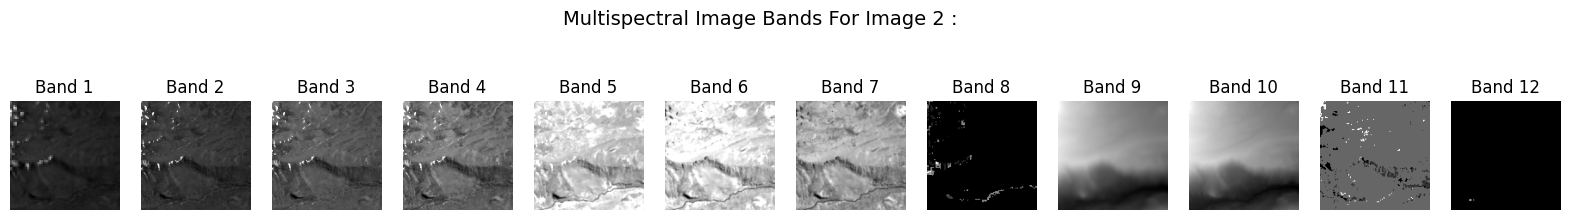

In [7]:
visualize_bands(images[10], title="Multispectral Image Bands For Image 2 :")

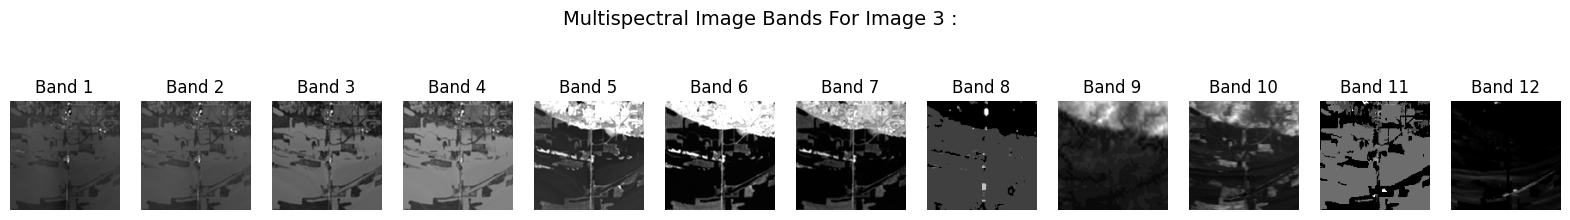

In [8]:
visualize_bands(images[15], title="Multispectral Image Bands For Image 3 :")

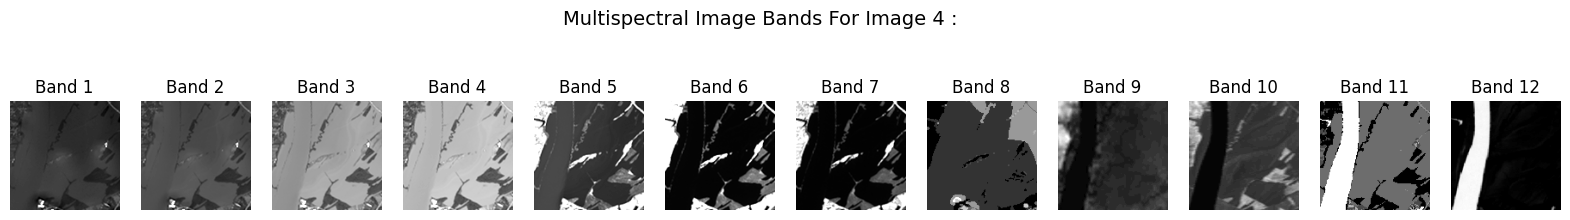

In [9]:
visualize_bands(images[20], title="Multispectral Image Bands For Image 4 :")

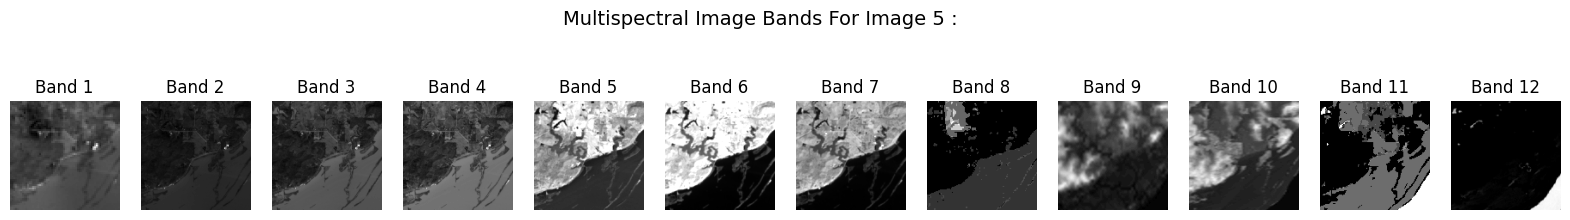

In [10]:
visualize_bands(images[25], title="Multispectral Image Bands For Image 5 :")

# **Splitting The Dataset :**

In [11]:
train_size = int(0.8 * len(images))  # 80% training, 20% validation
X_train, X_val = images[:train_size], images[train_size:]
y_train, y_val = masks[:train_size], masks[train_size:]

# **Building The Model Architecture , Compiling And Training :**

In [12]:
#  U-Net Model 
def complex_unet(input_shape=(128, 128, 12)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model



# Initialize the model
model = complex_unet(input_shape=(128, 128, 12))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping 
callbacks = [
    EarlyStopping(monitor="val_loss", patience=17, restore_best_weights=True)
]

# Train the model
history = model.fit(
    np.array(contrast_images[:train_size]), np.array(masks[:train_size]),
    validation_data=(np.array(contrast_images[train_size:]), np.array(masks[train_size:])),
    epochs=250,
    batch_size=32,
    callbacks=callbacks
)

print("Model training complete! ✅")


Epoch 1/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 51s 4s/step - accuracy: 0.7588 - loss: 1.0362 - val_accuracy: 0.8609 - val_loss: 0.4496
Epoch 2/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.8554 - loss: 0.4190 - val_accuracy: 0.8956 - val_loss: 0.3436
Epoch 3/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.8822 - loss: 0.3527 - val_accuracy: 0.9008 - val_loss: 0.2888
Epoch 4/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.8942 - loss: 0.3052 - val_accuracy: 0.9052 - val_loss: 0.2599
Epoch 5/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.8854 - loss: 0.3164 - val_accuracy: 0.9065 - val_loss: 0.2558
Epoch 6/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.8885 - loss: 0.3070 - val_accuracy: 0.9068 - val_loss: 0.2635
Epoch 7/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.8935 - loss: 0.2870 - val_accuracy: 0.9052 - val_loss: 0.2593
Epoch 8/250
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.9000 - loss: 0.2640 - val_accuracy: 0.9066 - val

# **Evaluating The Model Performance :**

## Confusion Matrix With Heatmap :

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


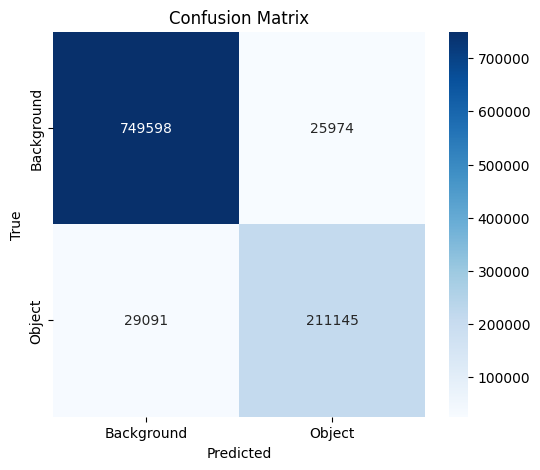

In [13]:
y_true = np.array(masks[train_size:]).flatten()

# Get predictions, convert to binary, and flatten
y_pred = (model.predict(np.array(contrast_images[train_size:])) > 0.5).astype(int).flatten()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Background', 'Object'], yticklabels=['Background', 'Object'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## IoU Matrix, Precision, Recall And F1-Score : 

In [14]:
water_iou = jaccard_score(y_true, y_pred, pos_label=1)
water_precision = precision_score(y_true, y_pred, pos_label=1)
water_recall = recall_score(y_true, y_pred, pos_label=1)
water_f1 = f1_score(y_true, y_pred, pos_label=1)

print(f"IoU (Water Class): {water_iou:.4f}")
print(f"Precision (Water Class): {water_precision:.4f}")
print(f"Recall (Water Class): {water_recall:.4f}")
print(f"F1-Score (Water Class): {water_f1:.4f}")


IoU (Water Class): 0.7932
Precision (Water Class): 0.8905
Recall (Water Class): 0.8789
F1-Score (Water Class): 0.8846


## Visualizing The Accuracy And The Loss Of The Model :

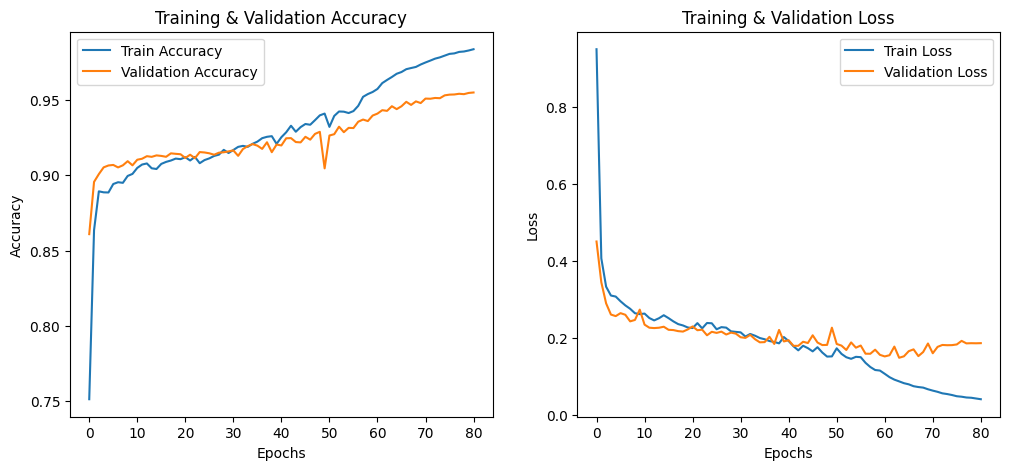

In [15]:
# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

# **Make Some Predictions :**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


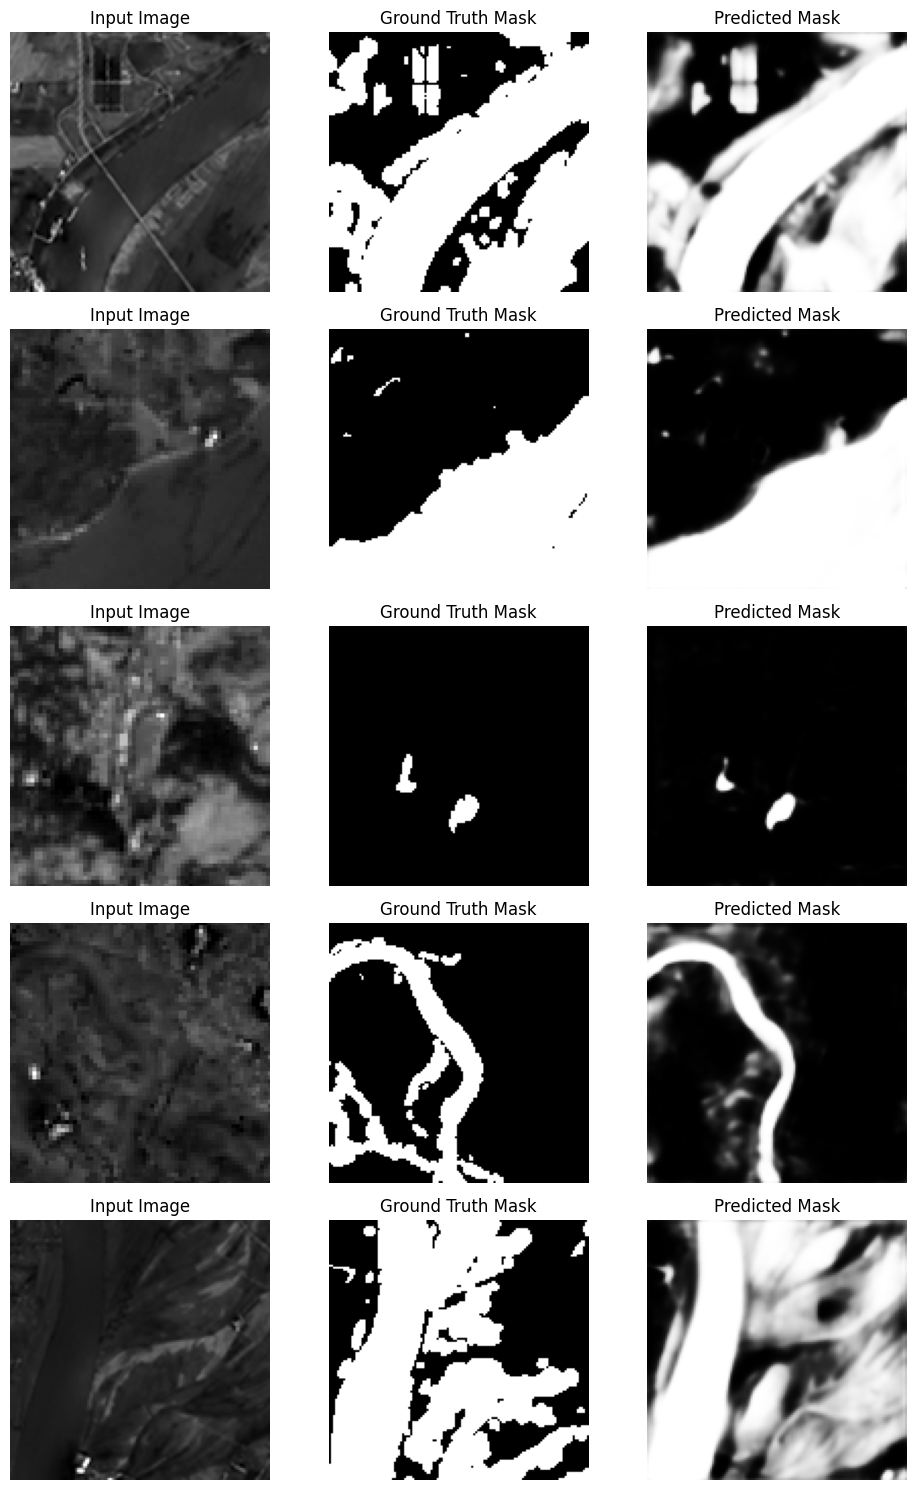

In [16]:
# Select random test images
num_samples = 5
indices = random.sample(range(len(contrast_images[train_size:])), num_samples)

fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

for i, idx in enumerate(indices):
    input_image = contrast_images[train_size + idx]
    ground_truth = masks[train_size + idx]
    
    # Predict mask
    predicted_mask = model.predict(np.expand_dims(input_image, axis=0))[0, :, :, 0]

    # Plot input image
    axes[i, 0].imshow(input_image[:, :, 0], cmap='gray')
    axes[i, 0].set_title("Input Image")
    axes[i, 0].axis("off")

    # Plot ground truth mask
    axes[i, 1].imshow(ground_truth, cmap='gray')
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis("off")

    # Plot predicted mask
    axes[i, 2].imshow(predicted_mask, cmap='gray')
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

# **Saving The Final Version Of The U-Net Model :**

In [17]:
model.save("U-Net Model (from scratch) - Object Detection.h5")